PHASE 1: DATA LOADING & PREPROCESSING

Dataset loaded successfully
Shape: (538285, 80)
Columns: 80

PHASE 2: TARGET VARIABLE CREATION

Target Variable: Fire_Severity
  Class 0 (Low): 1-2 units, <30 min, 1 alarm
  Class 1 (Medium): 3-5 units, 30-90 min, 1-2 alarms  
  Class 2 (High): 6+ units, >90 min, 3+ alarms

Class Distribution:
Fire_Severity
0    235620
1    256575
2     45969
Name: count, dtype: int64

Percentages:
Fire_Severity
0    43.782193
1    47.675987
2     8.541820
Name: proportion, dtype: float64

PHASE 2.5: EXPLORATORY DATA ANALYSIS


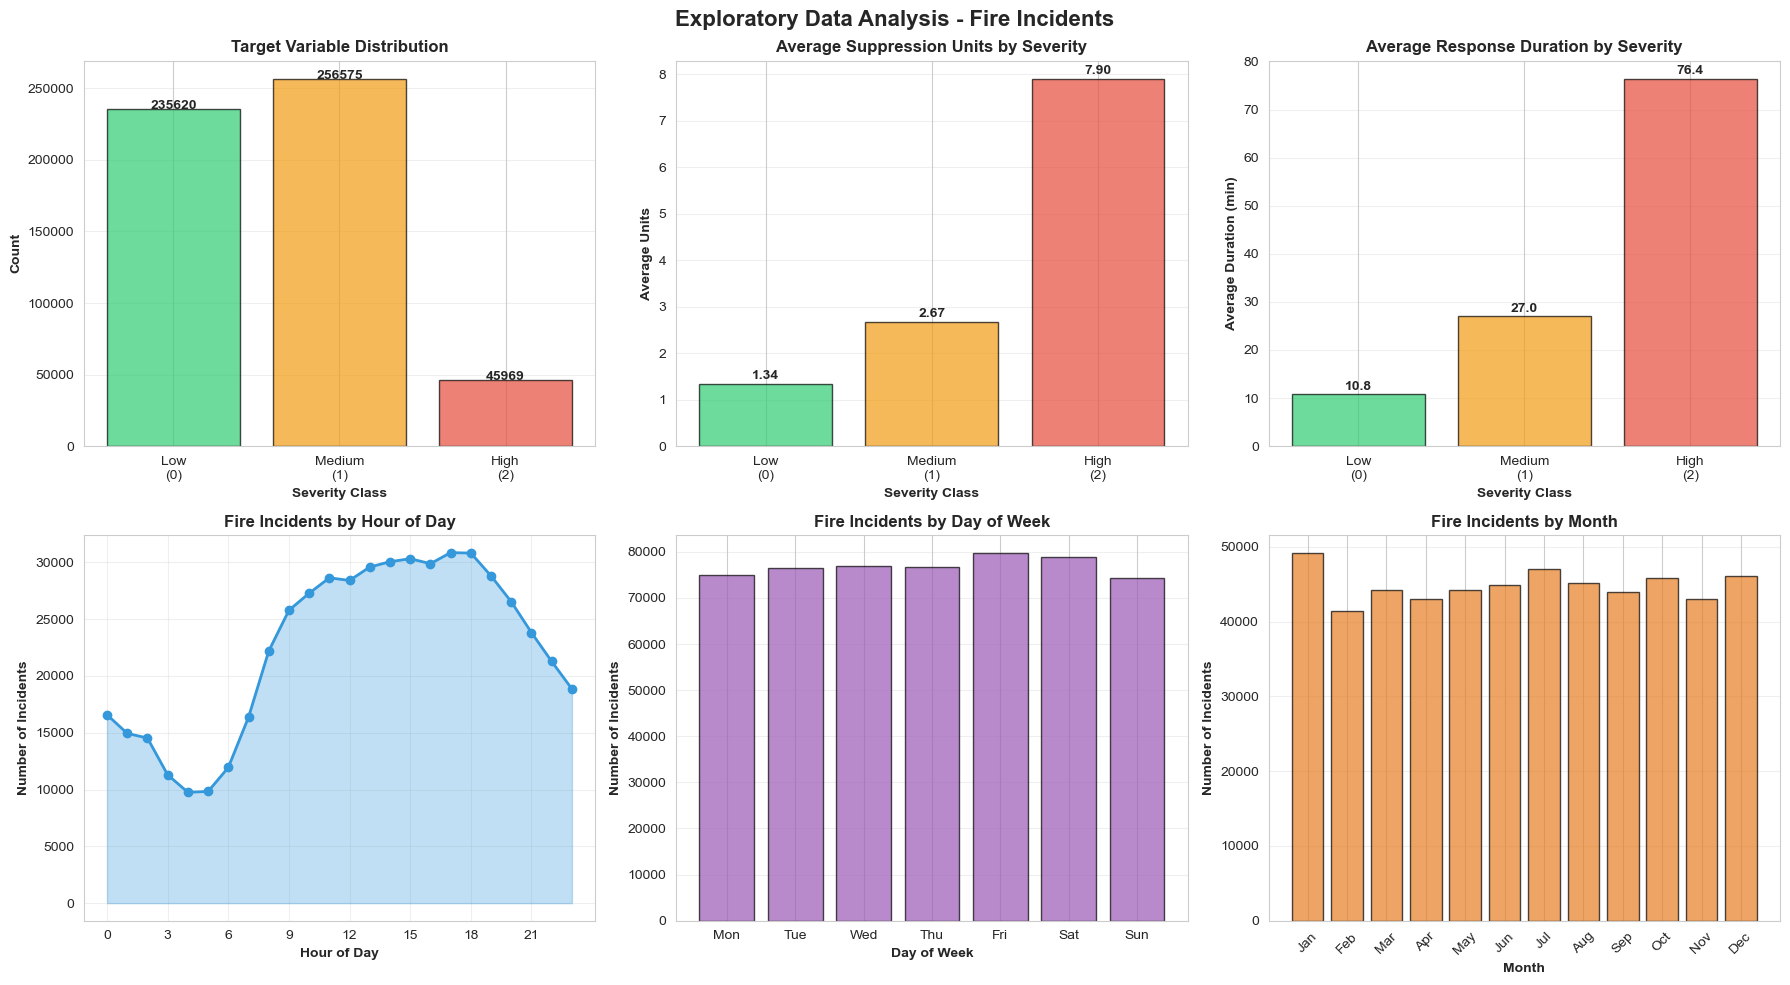


Generating correlation heatmap...


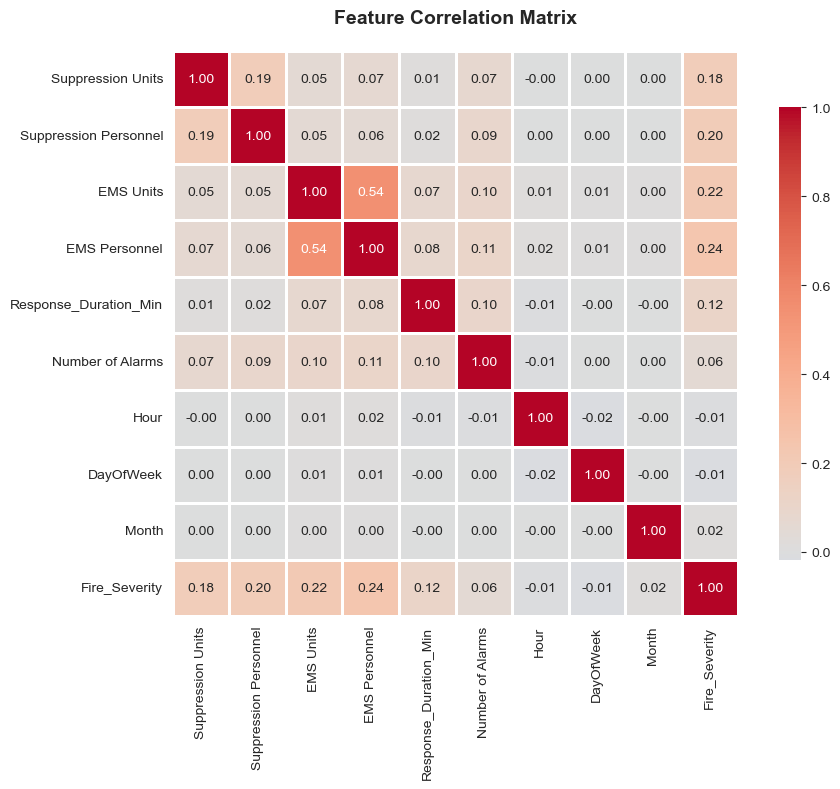


PHASE 3: FEATURE ENGINEERING

Features engineered:
  Temporal: Hour, DayOfWeek, Month, Season, IsWeekend, IsPeakHour
  Categorical: Neighborhood, Battalion, Situation, Property
  Aggregate: Neighborhood fire frequency and count

PHASE 4: FEATURE MATRIX PREPARATION

Final feature matrix: (538164, 29)
Total features: 29

PHASE 5: TRAIN-TEST SPLIT

Train set: (403623, 29)
Test set: (134541, 29)

Train class distribution:
Fire_Severity
0    176715
1    192431
2     34477
Name: count, dtype: int64

Test class distribution:
Fire_Severity
0    58905
1    64144
2    11492
Name: count, dtype: int64

PHASE 6: MODEL TRAINING
Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training Decision Tree...
All models trained successfully

PHASE 7: MODEL EVALUATION

Logistic Regression

Accuracy: 0.8137

Classification Report:
              precision    recall  f1-score   support

         Low       0.84      0.85      0.85     58905
      Medium       0.85      0.7

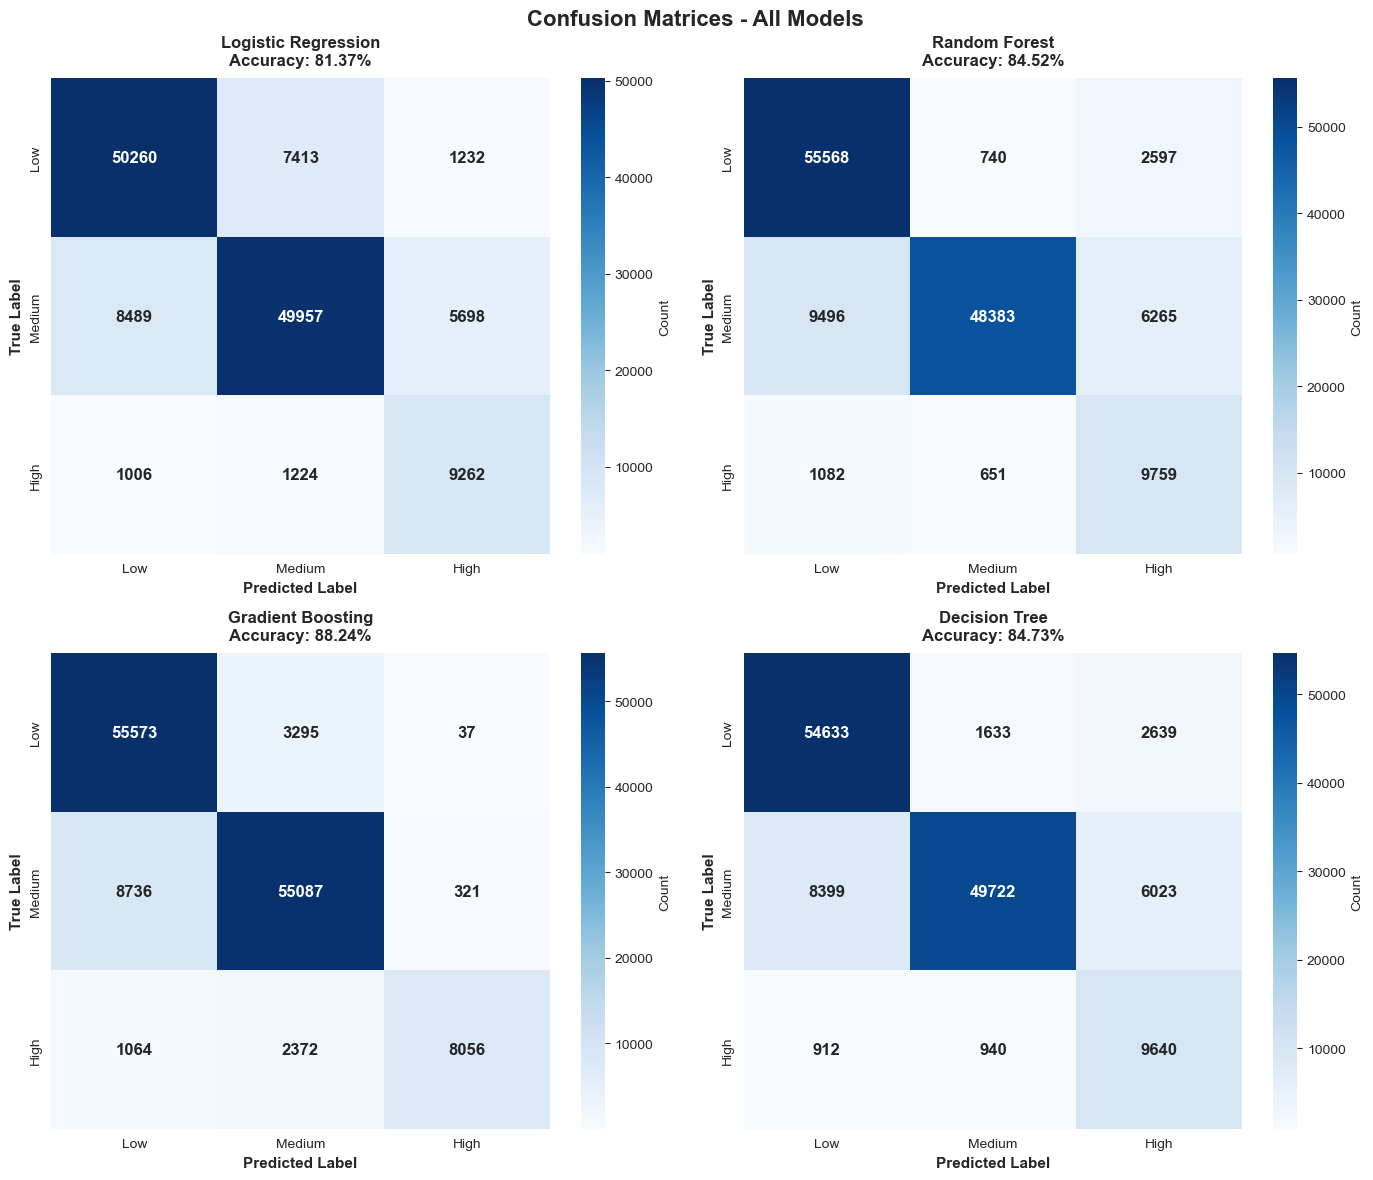


PHASE 8: RESULTS COMPARISON

              Model  Accuracy  Precision (Macro)  Precision (Weighted)  Recall (Macro)  Recall (Weighted)  F1-Score (Macro)  F1-Score (Weighted)  Training Time (s)
Logistic Regression    0.8137             0.7552                0.8236          0.8127             0.8137            0.7768               0.8161             1.6484
      Random Forest    0.8452             0.7787                0.8760          0.8489             0.8452            0.7954               0.8494             3.8657
  Gradient Boosting    0.8824             0.9048                0.8863          0.8344             0.8824            0.8619               0.8813           156.3342
      Decision Tree    0.8473             0.7773                0.8724          0.8472             0.8473            0.7969               0.8519             1.1837



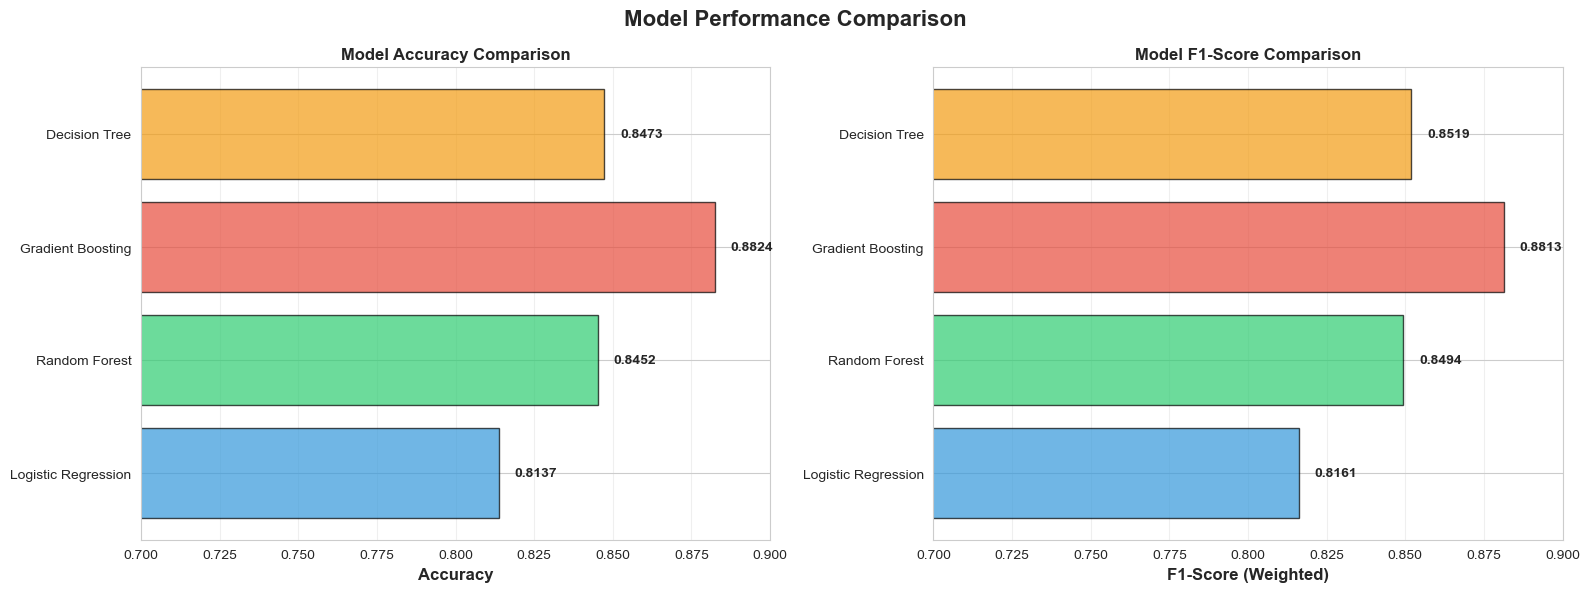


Top 10 Most Important Features (Random Forest):
                      Feature  Importance
        Suppression Personnel    0.637744
                    EMS Units    0.107984
                EMS Personnel    0.082927
     Property_Category_Street    0.044940
      Situation_Category_Fire    0.029902
     Situation_Category_Other    0.026519
     Situation_Category_Alarm    0.026057
Property_Category_Residential    0.007327
   Situation_Category_Medical    0.005913
            Neighborhood_Freq    0.005750



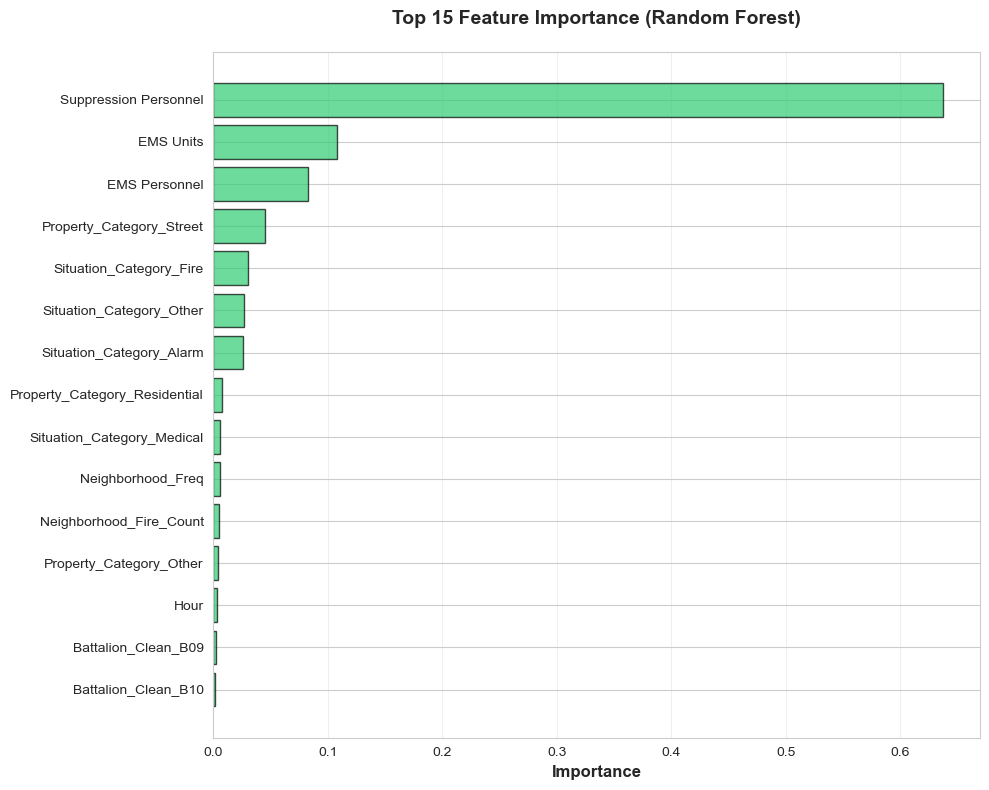


PROJECT COMPLETE

Best Model: Gradient Boosting
Best Accuracy: 0.8824

Files saved:
  - fire_severity_model_comparison.csv
  - feature_importance.csv

All visualizations displayed in output windows



In [1]:
"""
San Francisco Fire Severity Predictor - KDDM Project
Trinary Classification: Low, Medium, High Severity
With EDA and Confusion Matrix Visualizations (Display in Output)
"""

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)
import time

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================================================
# PHASE 1: DATA LOADING & PREPROCESSING
# ============================================================================

print("="*70)
print("PHASE 1: DATA LOADING & PREPROCESSING")
print("="*70)

df = pd.read_csv('fire-incidents.csv')
print(f"""
Dataset loaded successfully
Shape: {df.shape}
Columns: {len(df.columns)}
""")

# Convert datetime columns
datetime_cols = ['Alarm DtTm', 'Arrival DtTm', 'Close DtTm', 'Incident Date']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate response duration
df['Response_Duration_Min'] = (df['Close DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60

# Clean numeric columns
df['Suppression Units'] = pd.to_numeric(df['Suppression Units'], errors='coerce')
df['Number of Alarms'] = pd.to_numeric(df['Number of Alarms'], errors='coerce')
df['Suppression Personnel'] = pd.to_numeric(df['Suppression Personnel'], errors='coerce')

# ============================================================================
# PHASE 2: TARGET VARIABLE CREATION
# ============================================================================

print("="*70)
print("PHASE 2: TARGET VARIABLE CREATION")
print("="*70)

def create_severity_label(row):
    units = row['Suppression Units']
    duration = row['Response_Duration_Min']
    alarms = row['Number of Alarms']

    if pd.isna(units) or pd.isna(duration) or pd.isna(alarms):
        return np.nan

    # High severity: 6+ units OR >90 min OR 3+ alarms
    if units >= 6 or duration > 90 or alarms >= 3:
        return 2
    # Low severity: 1-2 units AND <30 min AND 1 alarm
    elif units <= 2 and duration <= 30 and alarms == 1:
        return 0
    # Medium severity: everything else
    else:
        return 1

df['Fire_Severity'] = df.apply(create_severity_label, axis=1)
df_clean = df.dropna(subset=['Fire_Severity']).copy()
df_clean['Fire_Severity'] = df_clean['Fire_Severity'].astype(int)

print(f"""
Target Variable: Fire_Severity
  Class 0 (Low): 1-2 units, <30 min, 1 alarm
  Class 1 (Medium): 3-5 units, 30-90 min, 1-2 alarms  
  Class 2 (High): 6+ units, >90 min, 3+ alarms

Class Distribution:
{df_clean['Fire_Severity'].value_counts().sort_index()}

Percentages:
{df_clean['Fire_Severity'].value_counts(normalize=True).sort_index() * 100}
""")

# ============================================================================
# PHASE 2.5: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("="*70)
print("PHASE 2.5: EXPLORATORY DATA ANALYSIS")
print("="*70)

# Create EDA visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Exploratory Data Analysis - Fire Incidents', fontsize=16, fontweight='bold')

# Extract temporal features for EDA
df_clean['Hour'] = df_clean['Alarm DtTm'].dt.hour
df_clean['DayOfWeek'] = df_clean['Alarm DtTm'].dt.dayofweek
df_clean['Month'] = df_clean['Alarm DtTm'].dt.month

# 1. Class Distribution
class_counts = df_clean['Fire_Severity'].value_counts().sort_index()
class_labels = ['Low\n(0)', 'Medium\n(1)', 'High\n(2)']
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0, 0].bar(range(3), class_counts.values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Severity Class', fontweight='bold')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].set_title('Target Variable Distribution', fontweight='bold')
axes[0, 0].set_xticks(range(3))
axes[0, 0].set_xticklabels(class_labels)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0, 0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# 2. Suppression Units by Severity
severity_units = df_clean.groupby('Fire_Severity')['Suppression Units'].mean().values
axes[0, 1].bar(range(3), severity_units, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Severity Class', fontweight='bold')
axes[0, 1].set_ylabel('Average Units', fontweight='bold')
axes[0, 1].set_title('Average Suppression Units by Severity', fontweight='bold')
axes[0, 1].set_xticks(range(3))
axes[0, 1].set_xticklabels(class_labels)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(severity_units):
    axes[0, 1].text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

# 3. Response Duration by Severity
severity_duration = df_clean.groupby('Fire_Severity')['Response_Duration_Min'].mean().values
axes[0, 2].bar(range(3), severity_duration, color=colors, alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Severity Class', fontweight='bold')
axes[0, 2].set_ylabel('Average Duration (min)', fontweight='bold')
axes[0, 2].set_title('Average Response Duration by Severity', fontweight='bold')
axes[0, 2].set_xticks(range(3))
axes[0, 2].set_xticklabels(class_labels)
axes[0, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(severity_duration):
    axes[0, 2].text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold')

# 4. Incidents by Hour
hour_counts = df_clean.groupby('Hour').size()
axes[1, 0].plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, color='#3498db')
axes[1, 0].fill_between(hour_counts.index, hour_counts.values, alpha=0.3, color='#3498db')
axes[1, 0].set_xlabel('Hour of Day', fontweight='bold')
axes[1, 0].set_ylabel('Number of Incidents', fontweight='bold')
axes[1, 0].set_title('Fire Incidents by Hour of Day', fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(range(0, 24, 3))

# 5. Incidents by Day of Week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_counts = df_clean.groupby('DayOfWeek').size()
axes[1, 1].bar(range(7), day_counts.values, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Day of Week', fontweight='bold')
axes[1, 1].set_ylabel('Number of Incidents', fontweight='bold')
axes[1, 1].set_title('Fire Incidents by Day of Week', fontweight='bold')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Incidents by Month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = df_clean.groupby('Month').size()
axes[1, 2].bar(range(1, 13), month_counts.values, color='#e67e22', alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Month', fontweight='bold')
axes[1, 2].set_ylabel('Number of Incidents', fontweight='bold')
axes[1, 2].set_title('Fire Incidents by Month', fontweight='bold')
axes[1, 2].set_xticks(range(1, 13))
axes[1, 2].set_xticklabels(month_names, rotation=45)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap
print("\nGenerating correlation heatmap...")
numeric_cols = ['Suppression Units', 'Suppression Personnel', 'EMS Units', 
                'EMS Personnel', 'Response_Duration_Min', 'Number of Alarms', 
                'Hour', 'DayOfWeek', 'Month', 'Fire_Severity']
corr_df = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ============================================================================
# PHASE 3: FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*70)
print("PHASE 3: FEATURE ENGINEERING")
print("="*70)

df_clean['IsWeekend'] = (df_clean['DayOfWeek'] >= 5).astype(int)
df_clean['IsPeakHour'] = df_clean['Hour'].apply(lambda x: 1 if (6 <= x <= 9) or (17 <= x <= 20) else 0)

def get_season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

df_clean['Season'] = df_clean['Month'].apply(get_season)

neighborhood_freq = df_clean['Analysis Neighborhood'].value_counts(normalize=True).to_dict()
df_clean['Neighborhood_Freq'] = df_clean['Analysis Neighborhood'].map(neighborhood_freq).fillna(0)

neighborhood_fire_counts = df_clean.groupby('Analysis Neighborhood')['Fire_Severity'].count()
df_clean['Neighborhood_Fire_Count'] = df_clean['Analysis Neighborhood'].map(neighborhood_fire_counts).fillna(0)

df_clean['Battalion_Clean'] = df_clean['Battalion'].fillna('Unknown')

def categorize_situation(situation):
    if pd.isna(situation):
        return 'Unknown'
    situation = str(situation).lower()
    if 'fire' in situation or 'smoke' in situation:
        return 'Fire'
    elif 'alarm' in situation or 'false' in situation:
        return 'Alarm'
    elif 'accident' in situation or 'vehicle' in situation:
        return 'Accident'
    elif 'medical' in situation or 'ems' in situation:
        return 'Medical'
    else:
        return 'Other'

df_clean['Situation_Category'] = df_clean['Primary Situation'].apply(categorize_situation)

def categorize_property(prop):
    if pd.isna(prop):
        return 'Unknown'
    prop = str(prop).lower()
    if 'dwelling' in prop or 'family' in prop or 'residential' in prop:
        return 'Residential'
    elif 'street' in prop or 'road' in prop:
        return 'Street'
    elif 'business' in prop or 'commercial' in prop or 'office' in prop:
        return 'Commercial'
    else:
        return 'Other'

df_clean['Property_Category'] = df_clean['Property Use'].apply(categorize_property)

print(f"""
Features engineered:
  Temporal: Hour, DayOfWeek, Month, Season, IsWeekend, IsPeakHour
  Categorical: Neighborhood, Battalion, Situation, Property
  Aggregate: Neighborhood fire frequency and count
""")

# ============================================================================
# PHASE 4: FEATURE MATRIX PREPARATION
# ============================================================================

print("="*70)
print("PHASE 4: FEATURE MATRIX PREPARATION")
print("="*70)

feature_columns = [
    'Hour', 'DayOfWeek', 'Month', 'Season', 'IsWeekend', 'IsPeakHour',
    'Suppression Personnel', 'EMS Units', 'EMS Personnel',
    'Neighborhood_Freq', 'Neighborhood_Fire_Count',
    'Situation_Category', 'Property_Category', 'Battalion_Clean'
]

X = df_clean[feature_columns].copy()
y = df_clean['Fire_Severity'].copy()

numeric_features = ['Suppression Personnel', 'EMS Units', 'EMS Personnel']
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())

categorical_features = ['Situation_Category', 'Property_Category', 'Battalion_Clean']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"""
Final feature matrix: {X.shape}
Total features: {X.shape[1]}
""")

# ============================================================================
# PHASE 5: TRAIN-TEST SPLIT
# ============================================================================

print("="*70)
print("PHASE 5: TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"""
Train set: {X_train.shape}
Test set: {X_test.shape}

Train class distribution:
{y_train.value_counts().sort_index()}

Test class distribution:
{y_test.value_counts().sort_index()}
""")

# ============================================================================
# PHASE 6: MODEL TRAINING
# ============================================================================

print("="*70)
print("PHASE 6: MODEL TRAINING")
print("="*70)

models = {}
training_times = {}

print("Training Logistic Regression...")
start_time = time.time()
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, 
                               random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
training_times['Logistic Regression'] = time.time() - start_time
models['Logistic Regression'] = ('scaled', lr_model)

print("Training Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, 
                                  class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)
training_times['Random Forest'] = time.time() - start_time
models['Random Forest'] = ('original', rf_model)

print("Training Gradient Boosting...")
start_time = time.time()
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
training_times['Gradient Boosting'] = time.time() - start_time
models['Gradient Boosting'] = ('original', gb_model)

print("Training Decision Tree...")
start_time = time.time()
dt_model = DecisionTreeClassifier(max_depth=15, min_samples_split=20, min_samples_leaf=10, 
                                  random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)
training_times['Decision Tree'] = time.time() - start_time
models['Decision Tree'] = ('original', dt_model)

print("All models trained successfully\n")

# ============================================================================
# PHASE 7: MODEL EVALUATION
# ============================================================================

print("="*70)
print("PHASE 7: MODEL EVALUATION")
print("="*70)

evaluation_results = []
confusion_matrices = {}

for model_name, (data_type, model) in models.items():
    print(f"""
{'='*70}
{model_name}
{'='*70}
""")

    X_test_use = X_test_scaled if data_type == 'scaled' else X_test
    y_pred = model.predict(X_test_use)

    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    evaluation_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Weighted)': recall_weighted,
        'F1-Score (Macro)': f1_macro,
        'F1-Score (Weighted)': f1_weighted,
        'Training Time (s)': training_times[model_name]
    })

    print(f"Accuracy: {accuracy:.4f}")
    print(f"""
Classification Report:
{classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'], zero_division=0)}
""")

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[model_name] = cm
    print(f"""
Confusion Matrix:
{cm}
""")

# ============================================================================
# PHASE 7.5: CONFUSION MATRIX VISUALIZATIONS
# ============================================================================

print("="*70)
print("PHASE 7.5: CONFUSION MATRIX VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

class_names = ['Low', 'Medium', 'High']

for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=ax, 
                annot_kws={'size': 12, 'weight': 'bold'})

    model_acc = evaluation_results[idx]['Accuracy']
    ax.set_title(f'{model_name}\nAccuracy: {model_acc:.2%}', 
                 fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# PHASE 8: RESULTS COMPARISON
# ============================================================================

print("\n" + "="*70)
print("PHASE 8: RESULTS COMPARISON")
print("="*70)

results_df = pd.DataFrame(evaluation_results).round(4)
print(f"""
{results_df.to_string(index=False)}
""")

# Model comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

model_names_plot = results_df['Model'].values
accuracies = results_df['Accuracy'].values
colors_plot = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

axes[0].barh(model_names_plot, accuracies, color=colors_plot, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_xlim(0.7, 0.9)
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

f1_scores = results_df['F1-Score (Weighted)'].values
axes[1].barh(model_names_plot, f1_scores, color=colors_plot, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('F1-Score (Weighted)', fontsize=12, fontweight='bold')
axes[1].set_title('Model F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_xlim(0.7, 0.9)
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[1].text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Feature Importance
rf_model = models['Random Forest'][1]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"""
Top 10 Most Important Features (Random Forest):
{feature_importance.head(10).to_string(index=False)}
""")

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'].values, 
         color='#2ecc71', alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Save results
results_df.to_csv('fire_severity_model_comparison.csv', index=False)
feature_importance.to_csv('feature_importance.csv', index=False)

print(f"""
{'='*70}
PROJECT COMPLETE
{'='*70}

Best Model: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}
Best Accuracy: {results_df['Accuracy'].max():.4f}

Files saved:
  - fire_severity_model_comparison.csv
  - feature_importance.csv

All visualizations displayed in output windows
""")
